In [66]:
#Importation des différentes fonctions qui servent dans ce script
import functions.functions_data as d
import functions.functions_affichage as a
import functions.functions_cocleogramme as c
from functions.ReccurentNetwork import RecurrentNetwork

from random import randint

from IPython.display import clear_output

from reservoirpy.nodes import Reservoir,FORCE,Ridge
from reservoirpy.mat_gen import Initializer,_scale_spectral_radius
from reservoirpy.observables import spectral_radius
from tqdm import tqdm

from ReccurentNetwork import *

import numpy as np
import copy
from numpy.linalg import eig

import spicy as sp
import matplotlib.pyplot as plt


In [2]:
#Code importé de ReservoirPy
def _rls(P, x, e):
    """Recursive Least Squares learning rule."""
    k = np.dot(P, x)
    xPx = np.dot(x.T, k)
    c = float(1.0 / (1.0 + xPx))
    P = P - c * np.outer(k, k)
    dw = -c * np.outer(e, k)

    return dw, P

# Réseaux de neurones

On cherche ici dans un premier temps à reprdoduire les figures les plus simples de l'article. 

Les mesures de l'article sont effectuées sur 2 réservoirs $ : 

  - le premier est dit entrainé : on va alors entrainer le réservoir et la sortie
  - le second lui est dit non entrainé : on entraine seulement la sortie
    

Ce premier script s'intéresse donc à la reproduction de l'entrainement des figures 3, 4 et 5 ainsi qu'aux résultas obtenus sur un réservoir entrainé.


## Expériences

Deux expériences quasiment similaires sont proposés pour un réservoir totalement entrainé. La seule différence entre ces dernières sont le nombre de neurones utilisés dans le réservoir : 

   - Soit N = 2100 pour des résultats robustes entre toutes les données pour un sujet
   - Soit N = 4000 pour des résultats robustes entre tous les sujets (5 au maximum)
    
Nous traiterons le premier  cas dans ce papier.

##### Méthode d'entrainement

Pour ce qui est de l'entrainement du réservoir nous allons procéder comme ceci : nous séparons notre entrée en deux parties : l'époque sensorielle et l'époque motricielle. 

###### Epoque sensorielle : 

Pour un sujet donné et parmit toutes les entrées différentes, pour chaque chiffre on selectionne une entrée moyenne. Cette entrée est injectée dans le réservoir sans bruit et sans target, on obtient alors une trajectoire resultante de taille (Timesteps x Nombre de neurones) pour chaque chiffre. Ces 10 trajectoires sont appelées les "innate trajectories" et seront les targets pour toutes les autres entrées durant l'entrainement du l'époque sensorielle en faisant bien attention à  ce que la dimension d'entrée des nouvelles entrées soit cohérente avec celle de l'innate trajectorie, on procédera alors pas une déformation linéaire de l'innate trajectory. De plus, du bruit sera présent durant l'entrainement.

###### Epoque motrice

On met dans le réservoir une matrice nulle (entrée à 0) et la target de l'époque motrice est l'activité autonome générée par le réservoir sur une durée comprenant la transition époque sensorielle/motrice et l'époque motrice.
Pour récupérer notre matrice, on utilisera la fonction target_xyz avec comme paramètre, innate = True 

##### Entrainement

On concatene maintenant l'innate trajectory de l'époque sensorielle et de l'époque motrice pour obtenir nos targets finales.

À noter, que chaque entrainement et test commence à -100ms avec le réseau initialisé selon une loi uniform de -1 à 1.
--> On laisse tourner le réservoir pendant 100ms à blanc ouis on met les entrées ????


###### Test
Les test effectués dans ce script seront fait sur le sujet 1

Données générales 

In [3]:
data = d.extract_data() #Données d'entrée
transcription = d.extract_target() #Données d'arrivée 

#Les données suivantes sont utilisés dans les fonctions mais pas dans le script ! 

freq_ent = 6*10**3  #fréquence d'entrée
T_ent = 1/freq_ent  #période d'entrée

freq_out = 10**3 #fréquence de sortie 
T_out = 1/freq_out #période de sortie

ampl_int = 5 #Amplitude d'entrée

Données du réservoir

In [5]:
N = 2100//10 #Nombre de neurones dans le réservoir
M = 12 #Nombres d'entrées
No = 3 #Nombres de sorties
tau = 25*10e-3
dt = 1e-3
lr = dt/tau
sr = 1.6 #spectral radius --> gain ?
g = 1.6 #le gain du réseau ?                             #je comprends pas trop cette donnée. 
pc = 0.2 # connectivité entre les neurones (pc dans l'article)
SD = g/np.sqrt(pc*N)
mu = 0
I0 = 0.005 

Wout = normal(No,N,loc=mu,scale = 1/np.sqrt(N))    #Matrice de sortie


Création de la matrice du réservoir : avec pas d'autapse
Puis bricolage pour réxupérer le rayon spectral voulu

In [6]:
W_r.init = Initializer(c.W_r)

W = _scale_spectral_radius(W_r.init, [N,N], sr)
W = W.toarray()

Création de la matrice d'entrée : chaque entrée k est projetée sur le neurone $(k-1)\frac{N}{M} + 1$ jusqu'au neurone $k\frac{N}{M}$ selon une loi normale 

In [7]:
Win = c.W_in(N,M)

Création des réservoirs

In [8]:
#Réservoir que l'on va entrainer
W_reservoir = copy.deepcopy(W)
reservoir_train = Reservoir(W=W_reservoir,Win=Win,equation='external',input_bias=False)

#Réservoir que l'on ne va pas entrainer 
reservoir_innate = reservoir_train.copy()

# Trajectoire inée 

Récupération des cocleograms avec une taille maximale pour chaque chiffre 

In [41]:
#Liste qui va contenir tout les cocleogramme maximums pour chaque chiffre
max_cocleogram =[]

for i in range(10):
    
    #Récupération des indices du cocléogramme le plus grand du chiffre i
    indS,indU,indD = c.ind_max_entrance(i,data)
    
    #Ajout à la liste
    max_cocleogram.append(c.entrance_cocleogram(indS,indS,indD,data,transcription).T)

Détermination des trajectoires inées  

In [42]:
#Liste qui va contenir toutes les trajectoires innées
innate_trajectories = []

for i in range(len(max_cocleogram)):
    
    #Récupération des trajectoires innées 
    initial_trajectory = reservoir_innate.run(max_cocleogram[i])
    
    #Ensuite on les ajoute
    innate_trajectories.append(initial_trajectory)

clear_output()

Activité de quelques neurones du réservoir sur les trajectoires innées

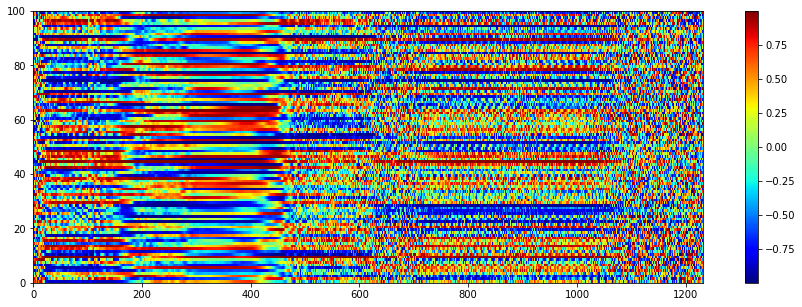

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
im = ax.pcolormesh(innate_trajectories[1][:,:100].T,cmap="jet")
fig.colorbar(im,ax = ax)

# Entrainement du réservoir 

Maintenant que les targets pour les différentes époques sont prêtes, il va falloir concaténer le tout. Donc pour chaque entrée, on va d'abord déformer linéairement la trajectoire innée de l'époque sensorielle, puis, on va ajouter la target de l'époque motrice en concaténant les matrices

In [15]:
X_input = []
X_target = []
for indS in [1,1,1] : 
    for indU in range(1,4):
        for indD in range(10):
            #Ajout de l'input
            X_input.append(np.transpose(c.entrance_cocleogram(indS, indU, indD,data,transcription)))
            
            #Récupération de la target
            target = innate_trajectories[indD] 

            #Concaténation et ajout dans la target
            X_target.append(target)

# ReservoirPy

Définition des valeurs qui vont me servir. Et, dans l'article, seulement 90% des connexions sont modifiées, je définis alors les indices qui ne seront pas modifés

In [16]:
#Matrice de gain
P = np.identity(N)

#Matrice de 0, permet de faire tourner le réservoir pendant 100 ms 
blanc = np.zeros((100,12))


#Nombre de connexion qui ne devront pas changer
nbr = int(N*0.1)

#Les indices des connexions qui ne changeront pas 
indice_rows = [randint(0,N-1) for i in range(nbr)]
indice_cols = [randint(0,N-1) for i in range(nbr)]

On laisse d'abord tourner le réservoir pendant 100ms (avec une période de 1ms), et on récupère l'état des neurones pour l'injecter dans un réservoir et commencer notre entrainement.

90it [02:35,  1.73s/it]

entrainement 90, moyenne :-0.0022526238785629416


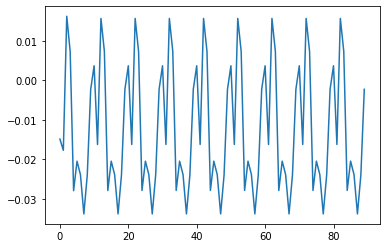

In [17]:
c = 0
error_total = []
for xi,xt in tqdm(zip(X_input,X_target)):
    
    #On laisse d'abord le réservoir tourner à vide pendant 100 ms
    Test = reservoir_train.run(blanc)
    
    #Ensuite on l'entraine
    
    #On calcul la sortie du réservoir pour une entrée
    x1 = reservoir_train.run(xi)
    
    #On calcul l'erreur 
    e = x1-xt
    
    #Et pour chaque pas de temps, on va modifier la matrice 
    for t in range(len(x1)):
        
        #Calcul de la variation de W et de la matrice de gain
        dW, P = _rls(P,x1[t],e[t])
        
        #On enlève 10% des changements
        for r,col in zip(indice_rows,indice_cols):
            dW[r,col] = 0
        
        #On enleve les poids réccurents (car des valeurs trop grandes)
        for k in range(N):
            dW[k,k] = 0
        
        #On modifie W
        W_reservoir += dW
        
    #On injecte W dans le réservoir pour les nouveux calculs
    reservoir_train.set_param("W",W_reservoir)

    clear_output()
    
    c += 1
    
    error_total.append(np.mean(e))
    
    print("entrainement {}, moyenne :{}".format(c,np.mean(e)))

#Affichage de l'évolution des valeurs de l'erreur : 
plt.plot(error_total)

Affichage des valeurs propores :

C:\Users\smoot\Desktop\Stage Mnemosyne\functions_trained_reservoir.py:535: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


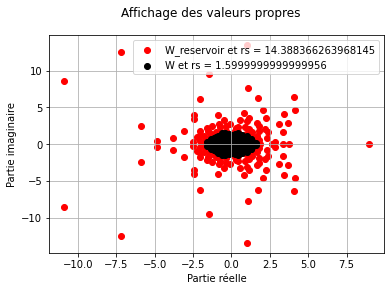

In [18]:
a.eigein_value(W_reservoir,W,"W_reservoir","W")

Réservoir après training :

Running Reservoir-1: 100%|███████████████████████████████████████████████████████| 2040/2040 [00:00<00:00, 6324.94it/s]


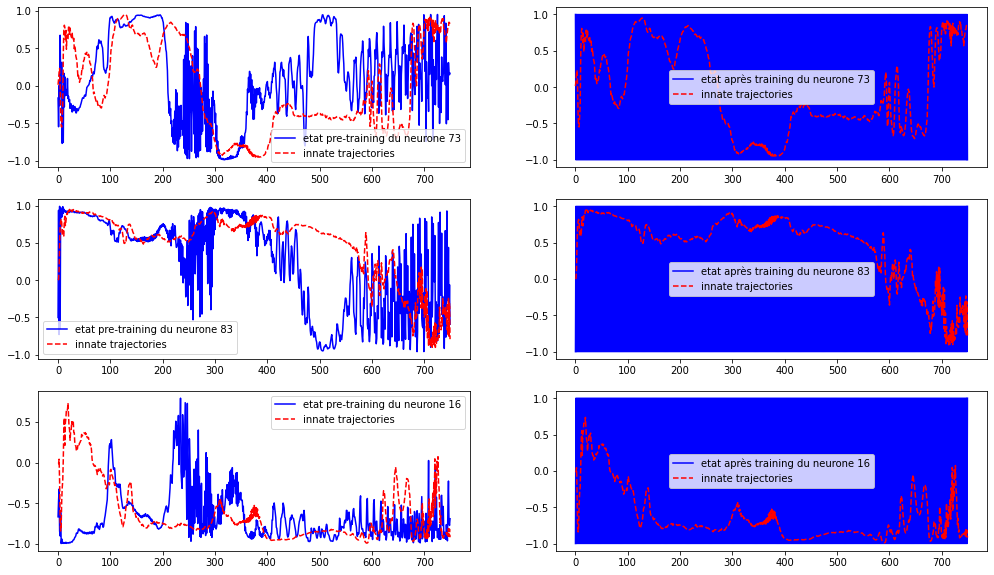

In [20]:
X_test = X_input[0]

X_pred_training = reservoir_train.run(X_test)
X_pred_pre_training = reservoir_innate.run(X_test)

target = X_target[0]

fig,ax = plt.subplots(figsize=(17,10),nrows = 3,ncols=2)

for i in range(3):
    neuron = randint(1,N)
    ax[i,0].plot(X_pred_pre_training[:750,neuron],"b",label = "etat pre-training du neurone " + str(neuron))
    ax[i,0].plot(target[:750,neuron],'--r',label = "innate trajectories")
    ax[i,0].legend()
    
    ax[i,1].plot(X_pred_training[:750,neuron],"b",label = "etat après training du neurone " + str(neuron))
    ax[i,1].plot(target[:750,neuron],'--r',label = "innate trajectories")
    ax[i,1].legend()

Le réservoir est totalement saturé 

Affichage de la matrice

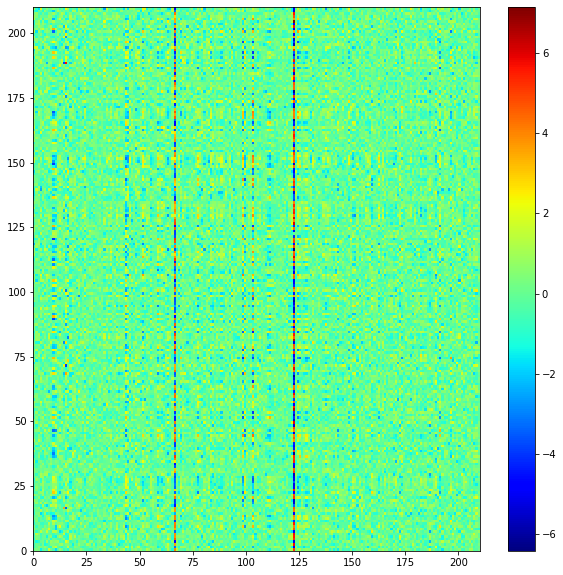

In [21]:
fig, ax0= plt.subplots(figsize=(10,10))

im = ax0.pcolormesh(W_reservoir, cmap="jet",)
fig.colorbar(im, ax=ax0)


# Entrainement de la sortie

Création des données d'entrainement

In [22]:
X_input = []
X_target = []
for indS in [1] : 
    for indU in range(1,4):
        for indD in range(10):
            #ajout de l'input
            X_input.append(np.transpose(c.entrance_cocleogram(indS, indU, indD,data,transcription)))
            
            #ajout de la target
            X_target.append(c.target_xyz(indS, indU, indD,data,transcription))

On crée le modèle

In [23]:
#Création des différents noeuds
readout_train = FORCE()

#Création du modèle complet
model = reservoir_train >> readout_train

Ensuite on entraine la sortie, normalement, chaque entrée est entrainée 25 fois

In [24]:
#Matrice vide
blanc = np.zeros((100,12))

#récupération des données 1 à 1
for xi,xt in tqdm(zip(X_input,X_target)):
    
    #nombre de fois qu'on entraine une entrée 
    nbr_training = 1
    
    for a in range(nbr_training):
        
        #On fait d'abord tourner le réservoir à vide
        reservoir_train.run(blanc)
        
        #Entrainement avec le noeud force : méthode online 
        model.train(xi,xt,reset = True)

        
    clear_output()

30it [01:13,  2.44s/it]


Une fois le réservoir entrainé, on le test sur 1 chiffre avec tout les détails.

In [25]:
#Test du réservoir

#Récupération d'un cocléogramme utilisé durant l'entrainement
indS,indU,indD = 1,3,6
X_test = np.transpose(c.entrance_cocleogram(indS,indU,indD,data,transcription))

#On fait tourner le réservoir
X_pred = model.run(X_test)
    
#récupération des états des neurones
states = c.etat(reservoir_train,indS,indU,indD,data,1)

#récupération de l'erreur commise sur la trajectoire d'un chiffre
erreur= c.error(X_pred,indS,indU,indD,data)


Running Model-0: 1886it [00:00, 3687.70it/s]                                                                           
Running Reservoir-0: 100%|███████████████████████████████████████████████████████| 1886/1886 [00:00<00:00, 7348.25it/s]


Affichage des résultats

1


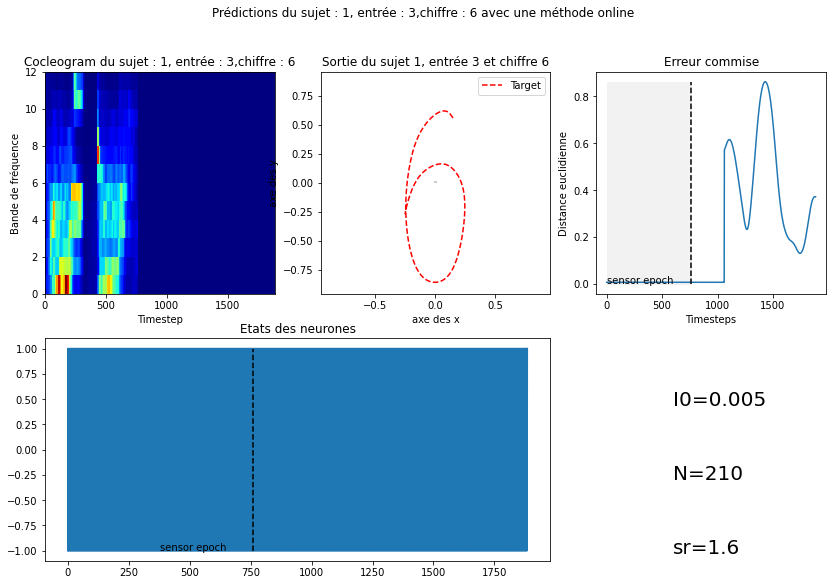

In [26]:
a.affiche(X_pred,indS,indU,indD,data,states,erreur,mode = "online",sr = sr,N=N,I0 = I0)

Ensuite on le test sur les 10 chiffres du même sujet et sur la même entrée

In [27]:
#Récupération de l'entrée et du sujet
indS,indU= 1,3

chiffre_pred=[]

#On calcule la prédictions pour chacun des 10 chiffres 
for i in range(10):
    
    #Récupération de l'entrée
    X_test = np.transpose(c.entrance_cocleogram(indS,indU,i,data,transcription))
    
    #On fait tourner le réservoir
    chiffre_pred.append(model.run(X_test))


Running Model-0: 1695it [00:00, 4034.77it/s]                                                                           
Running Model-0: 949it [00:00, 4115.70it/s]                                                                            
Running Model-0: 1505it [00:00, 3101.59it/s]                                                                           
Running Model-0: 1808it [00:00, 3921.69it/s]                                                                           
Running Model-0: 1218it [00:00, 3784.26it/s]                                                                           
Running Model-0: 1912it [00:00, 4237.75it/s]                                                                           
Running Model-0: 1886it [00:00, 4021.77it/s]                                                                           
Running Model-0: 1558it [00:00, 3876.85it/s]                                                                           
Running Model-0: 1690it [00:00, 5027.37i

Puis on affiche notre résultat

C:\Users\smoot\Desktop\Stage Mnemosyne\functions_trained_reservoir.py:324: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


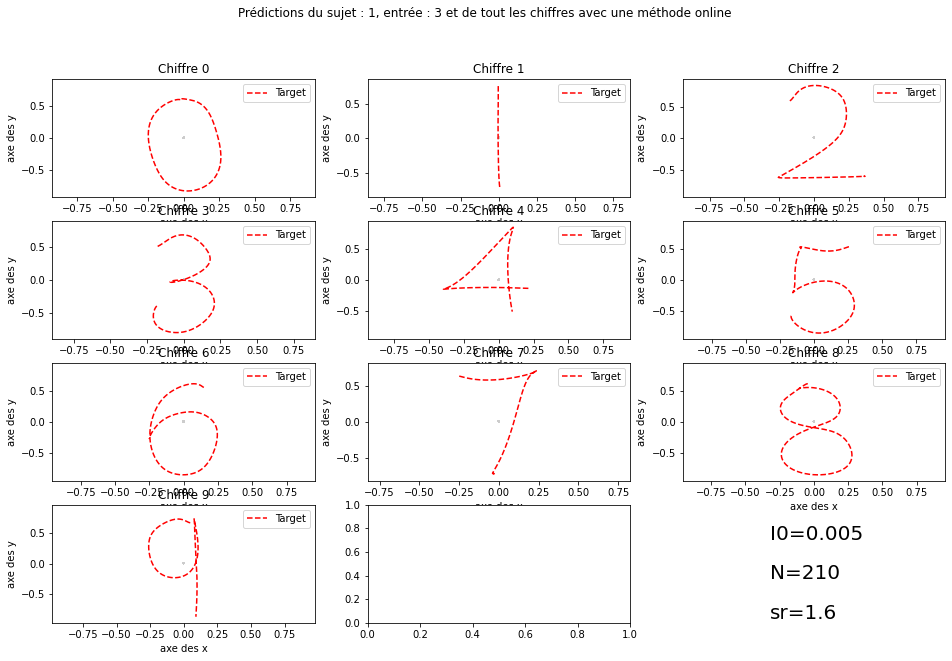

In [28]:
a.affiche_chiffre(chiffre_pred,indS,indU,data,mode="online",sr = sr,N=N,I0 = I0)

### Test RLS avec code de Vitay

Problème :
  - déformation linéaire : ça met les valeurs de mes trajectoires innées au dessus de un et en dessous de -1 
  - entrainement du RLS s'arrete quand l'erreur tend asymptotiquement vers une valeur 

In [29]:
####################
# Create the network
####################

W_rec = copy.deepcopy(W)

net = RecurrentNetwork(
    W_in = Win,
    W_rec = W,
    W_out = Wout,
    Ni = M, # Number of inputs
    N = N, # Number of recurrent neurons
    No = No, # Number of read-out neurons
    tau = 25.0, # Time constant of the neurons
    g = 1.6, # Synaptic strength scaling
    pc = 0.2, # Connection probability
    Io = 0.001, # Noise variance
    delta = 10.0, # Initial diagonal value of the P matrix
    P_plastic = 0.9, # Percentage of neurons receiving plastic synapses
)

In [67]:
####################
# Coordonnées innées
####################

#Liste qui va contenir toutes les trajectoires innées
innate_trajectories = []

for i in range(len(max_cocleogram)):
    
    #Récupération des trajectoires innées 
    stimulus = np.expand_dims(max_cocleogram[i],axis =2)
    initial_trajectory, _ = net.simulate(stimulus = stimulus, noise = False)
    
    #Ensuite on les ajoute
    innate_trajectories.append(initial_trajectory)

clear_output()

(2175, 12)


In [44]:
####################
# Données entrainement
####################

X_input = []
X_target = []
for indS in [1,1,1] : 
    for indU in range(1,4):
        for indD in range(10):
            #Ajout de l'input
            Input = np.expand_dims(c.entrance_cocleogram(indS, indU, indD,data).T)
            X_input.append(Input,axis=2)
            
            #Récupération de la target
            target = np.expand_dims(innate_trajectories[indD],axis = 2) 

            #Concaténation et ajout dans la target
            X_target.append(target)
            

In [46]:
####################
# Training reccurent weight
####################

nb_learning_trials_rec = len(X_input)

for i in range(nb_learning_trials_rec):
    
    print('Learning trial recurrent', i+1)
    s
    impulse = X_input[i]
    
    target_rc = X_target[i]
    
    print(np.shape(impulse),np.shape(target_rc))
    
    stop = np.shape(X_input[i])[0]
    
    _, _ = net.simulate(stimulus=impulse,
                        trajectory=target_rc,
                        learn_start= 0,
                        learn_stop=stop)

Learning trial recurrent 1
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:13<00:00, 156.09it/s]


\Loss: 1.0251233359148646
Learning trial recurrent 2
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:07<00:00, 165.92it/s]


\Loss: 1.0823405684011378
Learning trial recurrent 3
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:11<00:00, 142.11it/s]


\Loss: 0.9255075304722885
Learning trial recurrent 4
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:14<00:00, 142.98it/s]


\Loss: 1.084091717157166
Learning trial recurrent 5
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:10<00:00, 152.42it/s]


\Loss: 0.953694662129305
Learning trial recurrent 6
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:16<00:00, 140.76it/s]


\Loss: 0.9800336282164427
Learning trial recurrent 7
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:16<00:00, 155.95it/s]


\Loss: 0.9344619735749272
Learning trial recurrent 8
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:12<00:00, 152.07it/s]


\Loss: 0.8481522388834702
Learning trial recurrent 9
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:14<00:00, 136.16it/s]


\Loss: 0.9037015343588324
Learning trial recurrent 10
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:14<00:00, 154.03it/s]


\Loss: 0.862127703362407
Learning trial recurrent 11
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:14<00:00, 144.04it/s]


\Loss: 0.8098620543248173
Learning trial recurrent 12
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:09<00:00, 130.66it/s]


\Loss: 0.7857322782180985
Learning trial recurrent 13
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:12<00:00, 132.46it/s]


\Loss: 0.8099327833793244
Learning trial recurrent 14
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:14<00:00, 146.52it/s]


\Loss: 0.7837921056952156
Learning trial recurrent 15
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:11<00:00, 135.63it/s]


\Loss: 0.7717193547750429
Learning trial recurrent 16
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:15<00:00, 149.08it/s]


\Loss: 0.7823528091663711
Learning trial recurrent 17
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:16<00:00, 152.26it/s]


\Loss: 0.9208350967137026
Learning trial recurrent 18
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:13<00:00, 143.74it/s]


\Loss: 0.7835242160684184
Learning trial recurrent 19
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:12<00:00, 153.96it/s]


\Loss: 0.7434460075284346
Learning trial recurrent 20
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:13<00:00, 159.24it/s]


\Loss: 0.7067027615578794
Learning trial recurrent 21
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:14<00:00, 142.72it/s]


\Loss: 0.771111991426555
Learning trial recurrent 22
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:08<00:00, 143.69it/s]


\Loss: 0.7507583172779518
Learning trial recurrent 23
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:10<00:00, 156.03it/s]


\Loss: 0.7258965918970876
Learning trial recurrent 24
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:13<00:00, 149.19it/s]


\Loss: 0.7331574325451112
Learning trial recurrent 25
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:10<00:00, 148.39it/s]


\Loss: 0.7191668879322293
Learning trial recurrent 26
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:16<00:00, 143.90it/s]


\Loss: 0.6729899187228502
Learning trial recurrent 27
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:17<00:00, 147.04it/s]


\Loss: 0.7040959494644268
Learning trial recurrent 28
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:13<00:00, 137.32it/s]


\Loss: 0.6726905802990261
Learning trial recurrent 29
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:12<00:00, 153.97it/s]


\Loss: 0.7156936606091354
Learning trial recurrent 30
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:12<00:00, 168.75it/s]


\Loss: 0.680628126716965
Learning trial recurrent 31
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:13<00:00, 154.21it/s]


\Loss: 0.7221296364382077
Learning trial recurrent 32
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:08<00:00, 148.57it/s]


\Loss: 0.7280853325652765
Learning trial recurrent 33
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:11<00:00, 149.43it/s]


\Loss: 0.6882013710183478
Learning trial recurrent 34
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:13<00:00, 155.41it/s]


\Loss: 0.7052533466978115
Learning trial recurrent 35
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:10<00:00, 145.98it/s]


\Loss: 0.6877333248981168
Learning trial recurrent 36
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:16<00:00, 141.44it/s]


\Loss: 0.6770939967712869
Learning trial recurrent 37
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:17<00:00, 147.00it/s]


\Loss: 0.6659594913236753
Learning trial recurrent 38
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:12<00:00, 154.54it/s]


\Loss: 0.6508599484907953
Learning trial recurrent 39
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:15<00:00, 131.10it/s]


\Loss: 0.7352701676929783
Learning trial recurrent 40
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:16<00:00, 132.43it/s]


\Loss: 0.7023833268913775
Learning trial recurrent 41
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:14<00:00, 140.86it/s]


\Loss: 0.6990828034511429
Learning trial recurrent 42
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:09<00:00, 127.35it/s]


\Loss: 0.6845302775453667
Learning trial recurrent 43
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:11<00:00, 144.43it/s]


\Loss: 0.661413311211922
Learning trial recurrent 44
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:14<00:00, 142.18it/s]


\Loss: 0.6681658251528227
Learning trial recurrent 45
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:11<00:00, 141.29it/s]


\Loss: 0.66173054021623
Learning trial recurrent 46
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:15<00:00, 144.79it/s]


\Loss: 0.6217856954918783
Learning trial recurrent 47
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:15<00:00, 157.78it/s]


\Loss: 0.6706578038718849
Learning trial recurrent 48
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:14<00:00, 135.15it/s]


\Loss: 0.6680406895750447
Learning trial recurrent 49
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:12<00:00, 161.73it/s]


\Loss: 0.6809914077594164
Learning trial recurrent 50
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:13<00:00, 159.53it/s]


\Loss: 0.6612660155166799
Learning trial recurrent 51
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:14<00:00, 138.94it/s]


\Loss: 0.7028248234888357
Learning trial recurrent 52
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:07<00:00, 161.91it/s]


\Loss: 0.6750618666410446
Learning trial recurrent 53
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:10<00:00, 156.34it/s]


\Loss: 0.6504821825681446
Learning trial recurrent 54
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:12<00:00, 161.73it/s]


\Loss: 0.660855319151485
Learning trial recurrent 55
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:10<00:00, 157.56it/s]


\Loss: 0.6594660058850568
Learning trial recurrent 56
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:14<00:00, 160.19it/s]


\Loss: 0.6022201945659813
Learning trial recurrent 57
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:15<00:00, 160.47it/s]


\Loss: 0.6397087827081752
Learning trial recurrent 58
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:12<00:00, 156.55it/s]


\Loss: 0.6050016680830403
Learning trial recurrent 59
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:12<00:00, 164.28it/s]


\Loss: 0.7024342468712398
Learning trial recurrent 60
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:14<00:00, 151.07it/s]


\Loss: 0.5997399667185315
Learning trial recurrent 61
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:13<00:00, 146.70it/s]


\Loss: 0.670322869505201
Learning trial recurrent 62
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:10<00:00, 114.82it/s]


\Loss: 0.6443118139955819
Learning trial recurrent 63
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:10<00:00, 162.78it/s]


\Loss: 0.6176289821495666
Learning trial recurrent 64
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:15<00:00, 138.40it/s]


\Loss: 0.6433557275263975
Learning trial recurrent 65
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:10<00:00, 159.20it/s]


\Loss: 0.6477212616620472
Learning trial recurrent 66
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:15<00:00, 145.42it/s]


\Loss: 0.6013046947390203
Learning trial recurrent 67
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:18<00:00, 135.45it/s]


\Loss: 0.6214651618637604
Learning trial recurrent 68
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:12<00:00, 154.34it/s]


\Loss: 0.6513671818532442
Learning trial recurrent 69
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:12<00:00, 158.17it/s]


\Loss: 0.6324522297587536
Learning trial recurrent 70
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:15<00:00, 142.19it/s]


\Loss: 0.6347459302203212
Learning trial recurrent 71
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:13<00:00, 147.46it/s]


\Loss: 0.6757162961821727
Learning trial recurrent 72
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:07<00:00, 168.72it/s]


\Loss: 0.6443773673586426
Learning trial recurrent 73
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:11<00:00, 150.11it/s]


\Loss: 0.6192494655693296
Learning trial recurrent 74
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:13<00:00, 155.35it/s]


\Loss: 0.6388179253853293
Learning trial recurrent 75
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:10<00:00, 153.68it/s]


\Loss: 0.6822695917752178
Learning trial recurrent 76
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:14<00:00, 157.04it/s]


\Loss: 0.5918199251078237
Learning trial recurrent 77
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:16<00:00, 148.61it/s]


\Loss: 0.6665950521168555
Learning trial recurrent 78
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:15<00:00, 125.93it/s]


\Loss: 0.6214315626809471
Learning trial recurrent 79
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:17<00:00, 112.16it/s]


\Loss: 0.6616111392943657
Learning trial recurrent 80
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:14<00:00, 152.24it/s]


\Loss: 0.5855414571573282
Learning trial recurrent 81
(2040, 12, 1) (2040, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:12<00:00, 163.73it/s]


\Loss: 0.6673327486598146
Learning trial recurrent 82
(1231, 12, 1) (1231, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:07<00:00, 167.02it/s]


\Loss: 0.6413192412169826
Learning trial recurrent 83
(1680, 12, 1) (1680, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:11<00:00, 143.22it/s]


\Loss: 0.6072643999550125
Learning trial recurrent 84
(2076, 12, 1) (2076, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2076/2076 [00:14<00:00, 146.43it/s]


\Loss: 0.6272357399775335
Learning trial recurrent 85
(1602, 12, 1) (1602, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:10<00:00, 148.65it/s]


\Loss: 0.6107284558646898
Learning trial recurrent 86
(2311, 12, 1) (2311, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2311/2311 [00:14<00:00, 163.07it/s]


\Loss: 0.5923126971081183
Learning trial recurrent 87
(2516, 12, 1) (2516, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:16<00:00, 152.27it/s]


\Loss: 0.6242448119850591
Learning trial recurrent 88
(1903, 12, 1) (1903, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1903/1903 [00:12<00:00, 151.38it/s]


\Loss: 0.5657940471956604
Learning trial recurrent 89
(1990, 12, 1) (1990, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 1990/1990 [00:11<00:00, 168.23it/s]


\Loss: 0.6348421736824255
Learning trial recurrent 90
(2175, 12, 1) (2175, 210, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:14<00:00, 151.76it/s]

\Loss: 0.5925176445785807
